# Import Packages

In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sympy as sym
import statsmodels.api as sm
import typing as tp

In [67]:
from state_space.data_reader import (
    load_monthly_and_annual_ff_factors, 
    compute_monthly_returns
)

In [68]:
from state_space import (
    SymbolicStateSpaceModelViaMaximumLikelihood, 
    LambdaParameterTransformation, 
    RectangularParameterTransformation
)

# Load Data

In [69]:
data_directory_name = 'data'
ford_data_filename = os.path.join(data_directory_name, 'F_monthly.csv')
gspc_data_filename = os.path.join(data_directory_name, '^GSPC_monthly.csv')
ff_data_filename = os.path.join(data_directory_name, 'F-F_Research_Data_Factors_monthly.CSV')

In [70]:
ford_prices = pd.read_csv(ford_data_filename).set_index('Date')
gspc_prices = pd.read_csv(gspc_data_filename).set_index('Date')

Load Fama-French factors

In [71]:
ff_monthly, ff_annual = load_monthly_and_annual_ff_factors(ff_data_filename)

# Prepare Data

Compute Ford returns

In [72]:
ford_returns = compute_monthly_returns(ford_prices, name='ford')

Compute S&P 500 index returns

In [73]:
gspc_returns = compute_monthly_returns(gspc_prices, name='gspc')

Compute excess returns on both

In [74]:
gspc_excess_returns = gspc_returns - ff_monthly['RF']
ford_excess_returns = ford_returns - ff_monthly['RF']

Put Ford and S&P 500 returns in a single dataframe

In [75]:
joint_returns = pd.DataFrame({'ford': ford_returns, 'gspc': gspc_returns, 'rf': ff_monthly['RF']}).dropna()

In [76]:
joint_excess_returns = pd.DataFrame({'ford': ford_excess_returns, 'gspc': gspc_excess_returns}).dropna()

Restrict the time horizon from 1990 to 2004

In [77]:
restricted_joint_excess_returns = joint_excess_returns.query('Date >= 1990 and Date < 2004')

# Conditional Factor Model and State-Space Representation

## Stochastic Process Model

Consider a univariate linear factor model with time-varying coefficients, where the factor is the return on an equity index. This model can be written as

$r_t = \alpha_t + \beta_t r_{M, t} + e_t$

$\alpha_{t+1} = \alpha_t + \eta_t$

$\beta_{t+1} = \beta_t + \epsilon_t$

where $r_t$ is the excess return of the stock over period $t$ and $r_{M, t}$ is the excess return of the market over period $t$. The innovations $e$, $\eta$, and $\epsilon$ are both serially and mutually independent and distributed as follows:

$e_t \sim N(0, \sigma^2_e)$

$\eta_t \sim N(0, \sigma^2_{\eta})$

$\epsilon_t \sim N(0, \sigma^2_{\epsilon})$

## State Space Representation

This model can be represented in statespace form as:

$s_t = \begin{pmatrix} \alpha_t \\ \beta_t \end{pmatrix}$ (state), 

$y_t = r_t$ (observation)

$s_{t+1} = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} \cdot s_t + \begin{pmatrix} \eta_t \\ \epsilon_t \end{pmatrix}$

$y_t = \begin{pmatrix} 1 & r_{M, t} \end{pmatrix} \cdot s_t + e_t $

We can further combine the processes

$\begin{pmatrix} s_{t+1} \\ y_t \end{pmatrix} = \delta_t + \Phi_t s_t + u_t$, 

where

$\delta_t = \begin{pmatrix} 0 \\ 0 \\ 0 \end{pmatrix}$, $\Phi_t = \begin{pmatrix} 1 & 0 \\ 0 & 1 \\ 1 & r_{M, t} \end{pmatrix}$, $u_t = \begin{pmatrix} \eta_t \\ \epsilon_t \\ e_t \end{pmatrix}$

## Representation in SymPy

Initialize symbols

In [78]:
sigma_e_2, sigma_eta_2, sigma_epsilon_2, alpha, beta, r, r_M = \
    sym.symbols('sigma_e_2, sigma_eta_2, sigma_epsilon_2, alpha, beta, r, r_M')

Model parameters to be estimated

In [79]:
parameter_symbols = (sigma_e_2, sigma_eta_2, sigma_epsilon_2)

Define the state vector

In [80]:
state_vector_symbols = (alpha, beta)

Define the vector of observations

In [81]:
observation_vector_symbols = (r, )

Define mapping between data symbols and Pandas series/NumPy arrays

In [82]:
data_symbol_to_data_map = {r: restricted_joint_excess_returns['ford'], 
                           r_M: restricted_joint_excess_returns['gspc']}

Set starting values for the maximum likelihood estimation via numerical optimization

In [83]:
ford_return_std = np.std(restricted_joint_excess_returns['ford'])
parameter_symbols_to_start_parameters_map = {sigma_e_2: ford_return_std, 
                                             sigma_eta_2: ford_return_std,
                                             sigma_epsilon_2: ford_return_std}

Define transformation functions to ensure that the variance parameters remain positive (the optimizer is unconstrained)

In [84]:
# Using a vectorized transformation function (the same for all parameters)
parameter_transformation = \
    LambdaParameterTransformation(transform_function=lambda x: x**2, 
                                  untransform_function=lambda x: x**0.5)

# Using individual lower and upper bounds
# parameter_transformation = \
#     RectangularParameterTransformation(parameter_symbols=parameter_symbols, 
#                                        parameter_symbol_to_bounds_map={sigma_e_2: (0, np.inf), 
#                                                                        sigma_eta_2: (0, np.inf), 
#                                                                        sigma_epsilon_2: (0, np.inf)})

Construct transition matrix in SymPy

In [85]:
transition_matrix = sym.eye(2)
transition_matrix

Matrix([
[1, 0],
[0, 1]])

Matrix([
[1, 0],
[0, 1]])

Construct design matrix in SymPy

In [86]:
design_matrix = sym.Matrix([[1, r_M]])
design_matrix

Matrix([[1, r_M]])

Matrix([[1, r_M]])

Construct selection matrix in SymPy

In [87]:
selection_matrix = sym.eye(2)
selection_matrix

Matrix([
[1, 0],
[0, 1]])

Matrix([
[1, 0],
[0, 1]])

Construct state covariance matrix matrix in SymPy

In [88]:
state_covariance_matrix = sym.diagonalize_vector(sym.Matrix([sigma_eta_2, sigma_epsilon_2]))
state_covariance_matrix

Matrix([
[sigma_eta_2,               0],
[          0, sigma_epsilon_2]])

Matrix([
[sigma_eta_2,               0],
[          0, sigma_epsilon_2]])

Construct observation covariance matrix matrix in SymPy

In [89]:
observation_covariance_matrix = sym.Matrix([[sigma_e_2]])

Compile numeric state space representation for MLE from the symbolic definition

In [90]:
conditional_factor_model = \
    SymbolicStateSpaceModelViaMaximumLikelihood(parameter_symbols=parameter_symbols, 
                                                state_vector_symbols=state_vector_symbols, 
                                                observation_vector_symbols=observation_vector_symbols, 
                                                data_symbol_to_data_map=data_symbol_to_data_map, 
                                                parameter_symbols_to_start_parameters_map=parameter_symbols_to_start_parameters_map, 
                                                parameter_transformation=parameter_transformation, 
                                                design_matrix=design_matrix, 
                                                observation_covariance_matrix=observation_covariance_matrix, 
                                                selection_matrix=selection_matrix, 
                                                state_covariance_matrix=state_covariance_matrix, 
                                                transition_matrix=transition_matrix)

# Estimation

Fit the model using MLE (recall that we are fitting the three variance parameters)

In [91]:
res = conditional_factor_model.fit(disp=False)

## Estimates

In [92]:
print(res.summary())

                                        Statespace Model Results                                       
Dep. Variable:                                               y   No. Observations:                  168
Model:             SymbolicStateSpaceModelViaMaximumLikelihood   Log Likelihood                 148.798
Date:                                         Mon, 10 Feb 2020   AIC                           -291.596
Time:                                                 14:54:45   BIC                           -282.260
Sample:                                                      0   HQIC                          -287.806
                                                         - 168                                         
Covariance Type:                                           opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------


## Filtered and Smoothed State

Filtered $\alpha$

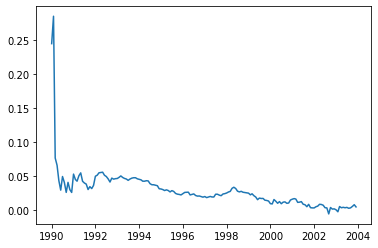

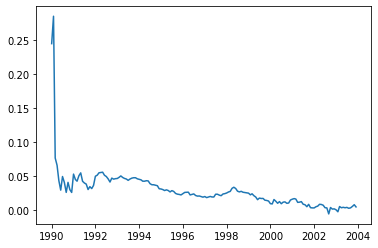

In [93]:
plt.plot(restricted_joint_excess_returns.index, res.filtered_state[0, :]);

Smoothed $\alpha$

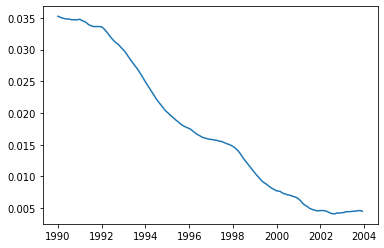

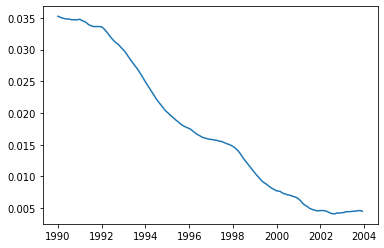

In [94]:
plt.plot(restricted_joint_excess_returns.index, res.smoothed_state[0, :]);

Filtered $\beta$

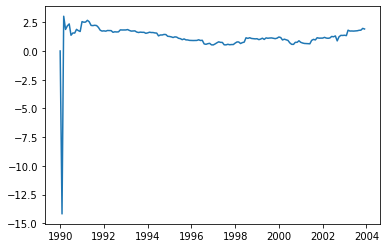

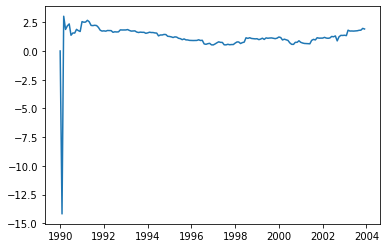

In [95]:
plt.plot(restricted_joint_excess_returns.index, res.filtered_state[1, :]);

Smoothed $\beta$

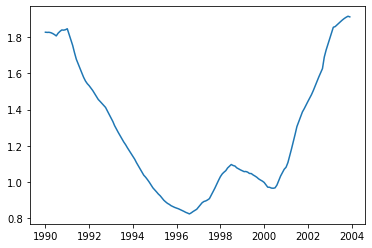

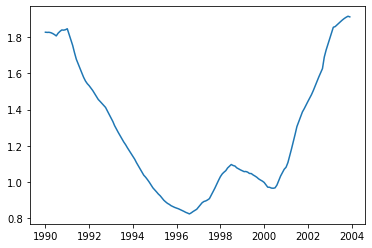

In [96]:
plt.plot(restricted_joint_excess_returns.index, res.smoothed_state[1, :]);